In [1]:
#ini-iPython

# Executando no diretório principal

In [2]:
import os
os.chdir("/home/vinicius/Dropbox/Projeto Mestrado/Codigos/RoboFEI-HT_Debug/AI/Visual_Memory") #Executando na pasta Vision
import sys
sys.path.append("./include")
sys.path.append("./src")
sys.path.append("./iPython")
#end-iPython

---- Imports ----

In [3]:
# Libraries to be used.
import sys
#des-iPython sys.path.append("../include")
#des-iPython sys.path.append("../src")

In [4]:
# The standard libraries used in the visual memory system.


In [5]:
# Used class developed by RoboFEI-HT.
from Basic import * # Class with implementations and basic variables
sym.init_printing() #debug-iPython

# Class to Speeds
Class responsible for managing the robot's possible speeds (me).
doxygen-iPython

In [6]:
#des-iPython class Speeds( ):
#ini-tab -> Iniciando código classe

---- Variables ----

# __movementslist
Velocity list of robot movements.
doxygen-iPython

In [7]:
__movementslist = [] #self-iPython __movementslist

# __u
Speed matrix $u_t$.
doxygen-iPython

In [8]:
__u = None #self-iPython __u

# __R
Speed error matrix $R_t$.
doxygen-iPython

In [9]:
__R = None #self-iPython __R

In [10]:
#ini-iPython

# ------- Lista de funções herdadas -------



# ------- Lista variaveis herdadas -------

#self-iPython p_x
#self-iPython p_y
#self-iPython v_x
#self-iPython v_y
#self-iPython a_x
#self-iPython a_y

#self-iPython vr_x
#self-iPython vr_y
#self-iPython omegar

# ------- Lista de funções -------

#self-iPython update
#self-iPython __getitem__

#end-iPython - Fim listas

# Constructor Class
Initializes basic network parameters and creates standard speeds.
doxygen-iPython

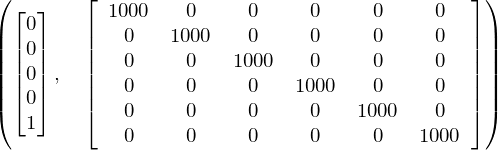

In [11]:
#des-iPython def __init__(self):
#ini-tab -> Criando construtor
__movementslist.append({
    "x_speed": sym.Matrix([
        [0], # v_x
        [0], # v_y
        [0], # a_x
        [0], # a_y
        [1], # cosntant
    ]),
        
    "R": sym.Matrix(sym.Identity(6)*0)
})



__t = sym.symbols("t") # Declaring variable time

p_x, p_y, v_x, v_y, a_x, a_y = sym.symbols("p_x, p_y, v_x, v_y, a_x, a_y") # Object state variables


# Robot speed and acceleration variables
vr_x, vr_y = sym.symbols("vr_x vr_y")
ar_x, ar_y = sym.symbols("ar_x ar_y")


# Kalman filter matrices
__u = sym.Matrix([
    [0],
    [0],
    [0],
    [0],
    [1],
])

__R = sym.Matrix(sym.Identity(6)*1000)

__u, __R #debug-iPython

In [12]:
#end-tab -> Finalizando construtor
#ini-iPython

## Teste construtor

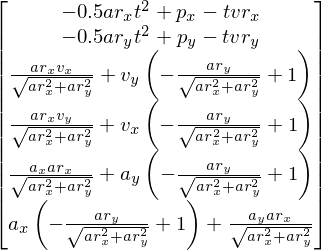

In [235]:
sym.Matrix([
    [p_x],
    [p_y],
    [v_x],
    [v_y],
    [a_x],
    [a_y],
])

px, py, p = sym.symbols("px py p")
px = ar_x
py = ar_y
p = sym.sqrt(px**2 + py**2)

C, S = sym.symbols("C S")
C = px/p
S = py/p


theta = sym.symbols("theta")

sym.Matrix([
    [-0.5*ar_x*__t**2 + p_x - __t*vr_x],
    [-0.5*ar_y*__t**2 + p_y - __t*vr_y],
    [v_y*(1-S) + v_x*C],
    [v_x*(1-S) + v_y*C],
    [a_y*(1-S) + a_x*C],
    [a_x*(1-S) + a_y*C],
]).subs([
#     [vr_x, 0],
#     [vr_y, 0],
#     [ar_x, 0],
#     [ar_y, 0],
])


# update
Adds average robot speeds or upgrades to speeds.
@param vector Observed speed.
doxygen-iPython

In [ ]:
#eself-iPython update
#edes-iPython def update(self, vector):
def update(vector):
    R_p = (p_x**2 + p_y**2)**0.5 # position vector module
    
#     print vector[0] + 1, ">", len(__movementslist), vector[0] + 1 > len(__movementslist)
#     print vector[0]
    if vector[0] + 1 > len(__movementslist):
        while vector[0] + 1 > len(__movementslist):
            __movementslist.append({
                "speed": sym.Matrix([
                    [0], # speed in x (vr_x)
                    [0], # speed in y (vr_y)
                    [0], # angular velocity (ωr)
                ]),

                "x_speed": sym.Matrix([
                    [0], # v_x
                    [0], # v_y
                    [0], # a_x
                    [0], # a_y
                ]),

                "U": sym.Matrix([
                    [0], # vr_x
                    [0], # vr_y
                    [1], # cos(ωr*t)
                    [0], # sin(ωr*t)
                    [1],
                ]),

                "R": copy(__R)
            })

    __movementslist[vector[0]]["x_speed"] = vector[1]
    __movementslist[vector[0]]["R"] = vector[2]


    # Calculating ωr of the robot
    __movementslist[vector[0]]["speed"][2] = (-a_x/R_p).subs([
        [p_x, __movementslist[vector[0]]["x_speed"][0]],
        [p_y, __movementslist[vector[0]]["x_speed"][1]],
        [a_x, __movementslist[vector[0]]["x_speed"][4]],
    ])

    # Calculating vr_x of the robot
    __movementslist[vector[0]]["speed"][0] = (-omegar*p_x - v_y).subs([
        [p_x, __movementslist[vector[0]]["x_speed"][0]],
        [v_y, __movementslist[vector[0]]["x_speed"][3]],
        [omegar, __movementslist[vector[0]]["speed"][2]]
    ])

    # Calculating vr_y of the robot
    __movementslist[vector[0]]["speed"][1] = (-omegar*p_y-v_x).subs([
        [p_y, __movementslist[vector[0]]["x_speed"][1]],
        [v_x, __movementslist[vector[0]]["x_speed"][2]],
        [omegar, __movementslist[vector[0]]["speed"][2]]
    ])

    # Calculating matrix U
    __movementslist[vector[0]]["U"] = __u.subs([
        [vr_x, __movementslist[vector[0]]["speed"][0]],
        [vr_y, __movementslist[vector[0]]["speed"][1]],
        [omegar, __movementslist[vector[0]]["speed"][2]],
    ]) #self-iPython update

In [ ]:
#ini-iPython

## Teste update

In [ ]:
vector = [
    2, # Movimento 
    
    sym.Matrix([ # Velocidades calculadas
        [2**0.5],
        [2**0.5],
        [1-2**0.5],
        [1-2**0.5],
        [-2],
        [-2],
    ]),
    
    
    copy(__R), # Erros calculados
]


update(vector)

vector, __movementslist[2]["speed"]
#end-iPython

# __getitem__
Returns the dictionary of motion vectors.
@param x Vector position to be accessed.
@return Returns the dictionary that will be used.
doxygen-iPython

In [ ]:
#eself-iPython __getitem__
#edes-iPython def __getitem__(self, x):
def __getitem__(x):
    if x + 1 > len(__movementslist):
        while x + 1 > len(__movementslist):
            __movementslist.append({
                "speed": sym.Matrix([
                    [0], # speed in x (vr_x)
                    [0], # speed in y (vr_y)
                    [0], # angular velocity (ωr)
                ]),

                "x_speed": sym.Matrix([
                    [0], # v_x
                    [0], # v_y
                    [0], # a_x
                    [0], # a_y
                ]),

                "U": sym.Matrix([
                    [0], # vr_x
                    [0], # vr_y
                    [1], # cos(ωr*t)
                    [0], # sin(ωr*t)
                    [1],
                ]),

                "R": copy(__R)
            })
    return __movementslist[x] #self-iPython __getitem__

In [ ]:
#ini-iPython

## Teste __getitem__

In [ ]:
a = 10
__getitem__(a)["U"], __getitem__(a)["R"]
#end-iPython

In [ ]:
#end-tab -> Finalizando classe

In [ ]:
#ini-iPython

# nova_variavel
.
doxygen-iPython

In [ ]:
nova_variavel = None #self-iPython nova_variavel

# nova_funcao
.
doxygen-iPython

In [ ]:
# eself-iPython nova_funcao
# edes-iPython def nova_funcao(self, variaveis_funcao):
def nova_funcao(variaveis_funcao):
    pass # self-iPython nova_funcao

In [ ]:
#ini-iPython

## Teste nova_funcao

In [ ]:

#end-iPython

In [ ]:
#end-iPython